# Background
- **Author**: `<林宜萱>`
- **Created At**: `<2025-10-26>`
- **Path to Training Data：extent-of-discount-rate-DE_train.csv**
- **Path to Testing Data：extent-of-discount-rate-DE_test.csv**
- **Model Specification 
    - Method：Random Forest Regression
    - Variables：
    Dependent Variable (y): DiscountRate  
    Independent Variables (X):  
    ["Age", "AccumulatedPositiveRate", "SalePeriod",  
 "PlayerGrowthRate1W", "PlayerGrowthRate2W", "PlayerGrowthRate1M",  
 "AvgFollowersGrowthRateDeviationRate1W","AvgFollowersGrowthRateDeviationRate2W","AvgFollowersGrowthRateDeviationRate1M",
 "PositiveRateGrowthRate1W", "PositiveRateGrowthRate2W", "PositiveRateGrowthRate1M",
 "DLC_since_last_discount", "Sequel_since_last_discount"]
    - Tuning Parameters:    
      -1W:{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}  
      -2W:{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}    
      -1M:{'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}  

    - Optimization Method：
    The model is trained via ensemble learning using Random Forests, which aggregates multiple decision trees trained on bootstrapped subsets of data to minimize prediction variance and capture non-linear relationships among variables.
- **Main Findings and Takeaways：**
    - In-sample `< R², RMSE>`:  
    1w(0.7787, 0.0922)、2w(0.7886, 0.0902)、1m(0.7986, 0.088)
    - Out-sample `< R², RMSE>`:  
    1w(0.5633, 0.1209)、2w(0.6134, 0.1138)、1m(0.6138, 0.1137)  
    - Feature Importance Ranking:  
  | 1 | AccumulatedPositiveRate |   
  | 2 | Age |   
  | 3 | AvgFollowersGrowthRateDeviationRate |   
  | 4 | PositiveRateGrowthRate |   
  | 5 | DiscountDuration |   
  | 6 | PlayerGrowthRate |   
  | 7 | MultiPlayer |   
  | 8 | DiscountFreq3M |   

- Interpretation:  
  - 模型在訓練資料上表現優異（R² 約 0.8），同時在測試資料上仍維持良好的解釋力（R² 約 0.6），顯示 Random Forest 能有效捕捉主要特徵模式，且未出現明顯的過度擬合。    
  - 在所有變數中，**AccumulatedPositiveRate**、**Age** 以及 **AvgFollowersGrowthRateDeviationRate** 對折扣率的影響最大。   
  - **long-term user sentiment** (positive review accumulation) and **community engagement** (follower and player growth) 是影響折扣策略幅度的主要因素。    
  - 相較之下，與**recent discount history** (DLC and sequel timing)相關的變數影響力較小，定價決策更可能受到遊戲表現與聲譽的影響，而非過往促銷紀錄。

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [52]:
df = pd.read_csv('../data/processed/extent-of-discount-rate-rate-update-DE.csv')
df_dummies = pd.get_dummies(df, columns=['GameID'], drop_first=True)

def prepare_xy(df, feature_cols, target_col):
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    # 將 bool 欄轉成 int
    X = X.astype({col: 'int' for col in X.select_dtypes(bool).columns})
    return X, y

# 直接用 sklearn 做隨機切分
train, test = train_test_split(
    df_dummies,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [53]:
df.columns

Index(['Date', 'GameID', 'Type', 'MultiPlayer', 'Publisher',
       'ConstantDiscount', 'Final price', 'OriginPrice', 'DiscountRate',
       'DiscountDuration', 'DiscountFreq3M', 'Age', 'AccumulatedPositiveRate',
       'SalePeriod', 'PlayerGrowthRate1W', 'PlayerGrowthRate2W',
       'PlayerGrowthRate1M', 'AvgFollowersGrowthRateDeviationRate1W',
       'AvgFollowersGrowthRateDeviationRate2W',
       'AvgFollowersGrowthRateDeviationRate1M', 'PositiveRateGrowthRate1W',
       'PositiveRateGrowthRate2W', 'PositiveRateGrowthRate1M',
       'DLC_since_last_discount', 'Sequel_since_last_discount'],
      dtype='object')

In [54]:
df_sale = df


In [55]:
df.head()

,Date,GameID,Type,MultiPlayer,Publisher,ConstantDiscount,Final price,OriginPrice,DiscountRate,DiscountDuration,...,PlayerGrowthRate2W,PlayerGrowthRate1M,AvgFollowersGrowthRateDeviationRate1W,AvgFollowersGrowthRateDeviationRate2W,AvgFollowersGrowthRateDeviationRate1M,PositiveRateGrowthRate1W,PositiveRateGrowthRate2W,PositiveRateGrowthRate1M,DLC_since_last_discount,Sequel_since_last_discount
0,2023-06-29,10,Action,1,Valve,0,18.0,186.0,0.903226,14,...,-0.032626,-0.039192,-0.292056,-0.277988,-0.215706,0.000053,0.000015,0.000023,0,0
1,2023-09-12,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.031983,0.006604,-0.434575,-0.417947,-0.407693,0.000004,0.000031,-0.000026,0,0
2,2023-11-21,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,-0.030716,0.027451,0.482403,0.097192,0.050472,-0.000146,-0.000165,-0.000152,0,0
3,2023-12-21,10,Action,1,Valve,0,19.0,186.0,0.897849,14,...,-0.032172,-0.014952,-0.092429,-0.040663,0.235283,0.000016,0.000014,-0.000011,0,0
4,2024-03-14,10,Action,1,Valve,0,18.0,186.0,0.903226,7,...,0.045146,0.009495,0.107584,0.033120,-0.043617,0.000002,-0.000022,-0.000005,0,0


In [56]:
# 定義特徵與目標 
base_features = [
    "Age", "AccumulatedPositiveRate", "SalePeriod", "DiscountFreq3M","MultiPlayer","DiscountDuration",
    #"DLC_since_last_discount", "Sequel_since_last_discount"
]

feature_sets = {
    "1W": ["PlayerGrowthRate1W", "AvgFollowersGrowthRateDeviationRate1W", "PositiveRateGrowthRate1W"],
    "2W": ["PlayerGrowthRate2W", "AvgFollowersGrowthRateDeviationRate2W", "PositiveRateGrowthRate2W"],
    "1M": ["PlayerGrowthRate1M", "AvgFollowersGrowthRateDeviationRate1M", "PositiveRateGrowthRate1M"]
}

y = df["DiscountRate"]

In [57]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Fit
    model.fit(X_train, y_train)

    # If model is RandomizedSearchCV → use best_estimator_
    if hasattr(model, "best_estimator_"):
        est = model.best_estimator_
    else:
        est = model

    # Feature importance
    if hasattr(est, "feature_importances_"):
        importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': est.feature_importances_
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances:")
        display(importances)
    else:
        print("\nThis model does not provide feature_importances_.")
    

    # Predictions
    y_pred_train = est.predict(X_train)
    y_pred_test = est.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)

    # Summary
    results = [{
        "Best Params": model.best_params_ if hasattr(model, "best_params_") else "N/A",
        "Train R²": round(train_r2, 4),
        "Test R²": round(test_r2, 4),
        "Train RMSE": round(train_rmse, 4),
        "Test RMSE": round(test_rmse, 4)
    }]

    result_df = pd.DataFrame(results, index=['result'])

    print(f"\n=== {name} ===")
    display(result_df)

    return result_df, y_pred_test


In [58]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def find_best_params_grid_searchCV_regression(X_train, y_train, X_test, y_test, param_grid, cv_splits=5):

    # 1. 初始化 RandomForestRegressor
    rf = RandomForestRegressor(random_state=71, max_features='sqrt')

    # 2. 設定交叉驗證策略（迴歸用 KFold）
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=71)

    # 3. 定義評分標準：我們用 r2 作為 scorer（也可以用 neg_mean_squared_error）
    scorer = make_scorer(r2_score)

    # 4. GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scorer,  # 使用 R² 作為評分
        cv=kf,
        verbose=1,
        n_jobs=-1
    )

    # 5. 執行網格搜尋（只用 training set 來 fit）
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # 6. 預測 train / test
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # 7. 計算指標
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = rmse(y_train, y_pred_train)
    test_rmse = rmse(y_test, y_pred_test)

    # 8. 準備輸出表格
    results = {
        "Train R2": [round(train_r2, 4)],
        "Test R2": [round(test_r2, 4)],
        "Train RMSE": [round(train_rmse, 4)],
        "Test RMSE": [round(test_rmse, 4)],
    }
    df = pd.DataFrame(results, index=["RandomForest"])

    # 9. 回傳最佳參數、結果表、以及最佳模型
    return grid_search.best_params_, df, best_model


In [59]:
feature_cols = [
    "Age", "AccumulatedPositiveRate", "DiscountDuration","DiscountFreq3M", "MultiPlayer", "SalePeriod",
    "PlayerGrowthRate1M", "AvgFollowersGrowthRateDeviationRate1M", "PositiveRateGrowthRate1M"]
baseline_model = RandomForestRegressor(      
    n_estimators=200,
    max_features='sqrt',
    max_depth=6,
    min_samples_split=2,
    random_state=71
)

In [60]:
X_train, y_train = prepare_xy(train, feature_cols, 'DiscountRate')
X_test, y_test = prepare_xy(test, feature_cols, 'DiscountRate')

In [61]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 3, 4, 5, 8, 10]
}

best_param, result_df, best_model = find_best_params_grid_searchCV_regression(
    X_train, y_train, X_test, y_test, param_grid
)

print("Best params:", best_param)
print(result_df)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\user\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
              Train R2  Test R2  Train RMSE  Test RMSE
RandomForest    0.7986   0.6138       0.088     0.1137


In [62]:
from sklearn.model_selection import learning_curve


model = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',
    max_depth=7,
    min_samples_split=2,
    min_samples_leaf=2,
    bootstrap=True
)
result1, y_pred_baseline = evaluate_model('baseline', baseline_model, X_train, y_train, X_test, y_test)
result2, y_pred_selection = evaluate_model('selection', model, X_train, y_train, X_test, y_test)

combined_results = pd.concat(
    [result1, result2],
    keys=['baseline', 'selection']
)

print("\n模型比較結果:")
print(combined_results)


Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.363628
7,AvgFollowersGrowthRateDeviationRate1M,0.167290
0,Age,0.153827
8,PositiveRateGrowthRate1M,0.102942
2,DiscountDuration,0.078271
6,PlayerGrowthRate1M,0.067601
4,MultiPlayer,0.033331
3,DiscountFreq3M,0.024638
5,SalePeriod,0.008473



=== baseline ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7308,0.5476,0.1017,0.1231



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.367905
0,Age,0.167542
7,AvgFollowersGrowthRateDeviationRate1M,0.138484
8,PositiveRateGrowthRate1M,0.113012
6,PlayerGrowthRate1M,0.072718
2,DiscountDuration,0.071404
4,MultiPlayer,0.033598
3,DiscountFreq3M,0.024229
5,SalePeriod,0.011110



=== selection ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7901,0.6032,0.0898,0.1153



模型比較結果:
                 Best Params  Train R²  Test R²  Train RMSE  Test RMSE
baseline  result         N/A    0.7308   0.5476      0.1017     0.1231
selection result         N/A    0.7901   0.6032      0.0898     0.1153


#### 檢查共線性

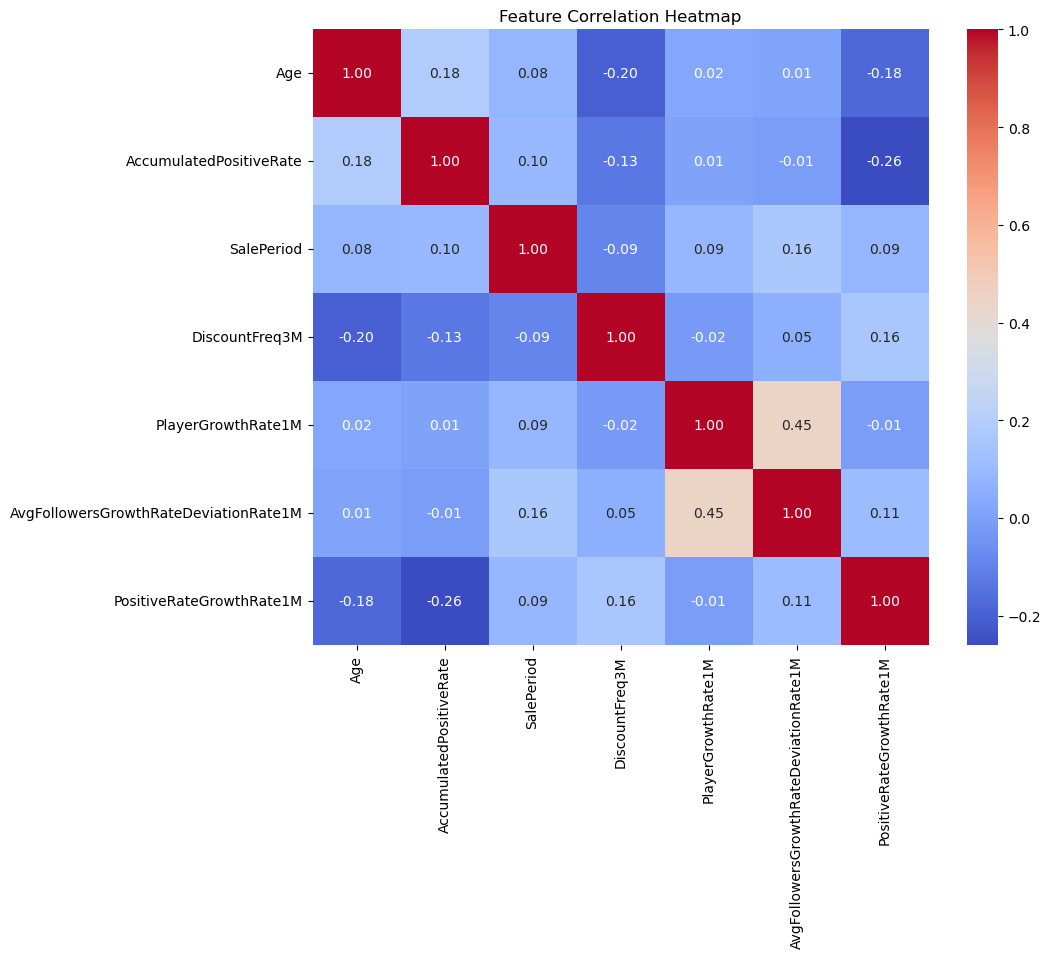

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# 只選數值型特徵（排除目標變數與時間）
features = ["Age", "AccumulatedPositiveRate", "SalePeriod",
            "DiscountFreq3M", "PlayerGrowthRate1M", "AvgFollowersGrowthRateDeviationRate1M",
            "PositiveRateGrowthRate1M"]
            #"DLC_since_last_discount","Sequel_since_last_discount"]

corr = df[features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.363628
7,AvgFollowersGrowthRateDeviationRate1M,0.167290
0,Age,0.153827
8,PositiveRateGrowthRate1M,0.102942
2,DiscountDuration,0.078271
6,PlayerGrowthRate1M,0.067601
4,MultiPlayer,0.033331
3,DiscountFreq3M,0.024638
5,SalePeriod,0.008473



=== baseline ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7308,0.5476,0.1017,0.1231



Feature Importances:


,Feature,Importance
1,AccumulatedPositiveRate,0.374953
0,Age,0.164792
7,AvgFollowersGrowthRateDeviationRate1M,0.143324
8,PositiveRateGrowthRate1M,0.110299
2,DiscountDuration,0.071877
6,PlayerGrowthRate1M,0.065384
4,MultiPlayer,0.035950
3,DiscountFreq3M,0.023443
5,SalePeriod,0.009979



=== selection ===


,Best Params,Train R²,Test R²,Train RMSE,Test RMSE
result,N/A,0.7871,0.5911,0.0905,0.117


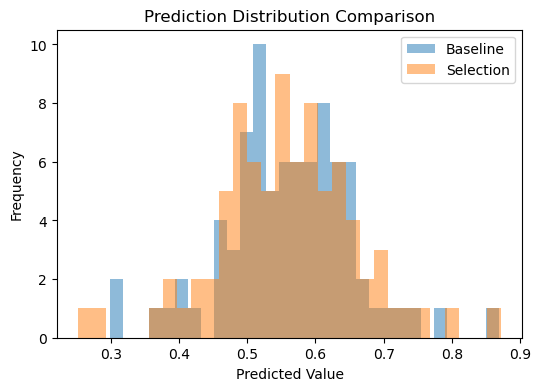

In [64]:
def compare_prediction_distributions(preds, labels):
    plt.figure(figsize=(6,4))

    for y_pred, label in zip(preds, labels):
        plt.hist(y_pred, bins=30, alpha=0.5, label=label)

    plt.title("Prediction Distribution Comparison")
    plt.xlabel("Predicted Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
result1, y_pred_baseline = evaluate_model("baseline", baseline_model, X_train, y_train, X_test, y_test)
result2, y_pred_selection = evaluate_model("selection", model, X_train, y_train, X_test, y_test)

compare_prediction_distributions(
    [y_pred_baseline, y_pred_selection],
    ["Baseline", "Selection"]
)


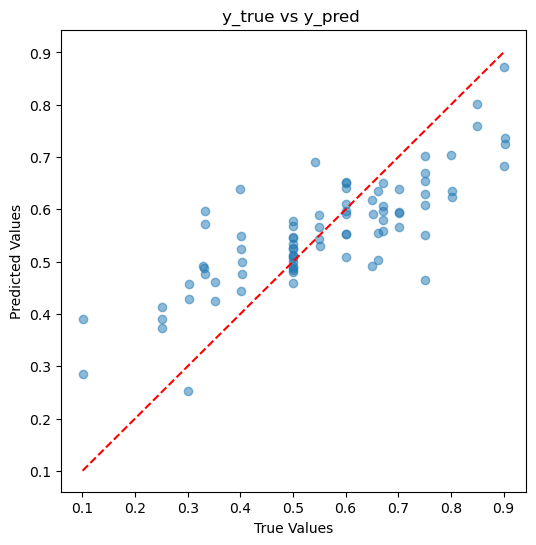

In [65]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_selection, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--')  # 理想45度線
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"y_true vs y_pred ")
plt.show()
